<a href="https://colab.research.google.com/github/Notsantana/capstone-project-design-exemplar/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install --upgrade tensorflow
!pip install scikit-learn
!pip install numpy
!pip install nltk
!pip install wordcloud
!pip install keras
!pip install pickle5

In [ ]:
#Import required Libraries
import pandas as pd
import numpy as np
import re

#Libraies to clean the data
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#library for data Visualization
import wordcloud
import matplotlib.pyplot as plt

#library and function for tokanization and vectorization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Importing libraries to build our models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Dense, Embedding, Flatten, SpatialDropout1D, SpatialDropout1D, LSTM

#import classification report
from sklearn.metrics import classification_report, accuracy_score

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
file_path = '/content/customer_reviewers.tsv'

data = pd.read_csv(file_path, delimiter='\t')

print(data.head())

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  


In [ ]:
#Print at least the first ten rows of your

data.columns=["rating","date","variation","reviews","feedback"]
print(data.shape)
data.head(10)

(3150, 5)


,rating,date,variation,reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [ ]:
#Verify that your data does not contains missing values.

if data['reviews'].isnull().any():

    data = data.dropna(subset=['reviews'])

data['reviews'] = data['reviews'].apply(lambda word: ' '.join(word.lower() for word in word.split()))

data['reviews'] = data['reviews'].str.replace('\d+', ' ', regex=True)

data['reviews'] = data['reviews'].str.replace('\W', ' ', regex=True)

print(data.shape)
data.head()

(3150, 5)


,rating,date,variation,reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love my echo,1
1,5,31-Jul-18,Charcoal Fabric,loved it,1
2,4,31-Jul-18,Walnut Finish,sometimes while playing a game you can answer...,1
3,5,31-Jul-18,Charcoal Fabric,i have had a lot of fun with this thing my ...,1
4,5,31-Jul-18,Charcoal Fabric,music,1


In [ ]:
#Clean the reviews from stop words, create a function that process this task the function must return a DataFrame with non stopwords.

def removestopwords(DataFrame):
  stopwords_list = set(stopwords.words('english'))
  DataFrame['reviews'] = DataFrame['reviews'].apply(lambda word: ' '.join([word for word in word.split() if word not in stopwords_list]))
  return DataFrame

removestopwords(data)

,rating,date,variation,reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love echo,1
1,5,31-Jul-18,Charcoal Fabric,loved,1
2,4,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1
3,5,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs control ...,1
4,5,31-Jul-18,Charcoal Fabric,music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,perfect kids adults everyone,1
3146,5,30-Jul-18,Black Dot,listening music searching locations checking t...,1
3147,5,30-Jul-18,Black Dot,love things running entire home tv lights ther...,1
3148,5,30-Jul-18,White Dot,complaint sound quality great mostly use comma...,1


love echo loved sometimes playing game answer question correctly alexa says got wrong answers like able turn lights away home lot fun thing yr old learns dinosaurs control lights play games like categories nice sound playing music well music received echo gift needed another bluetooth something play music easily accessible found smart speaker wait see else without cellphone cannot use many features ipad see use great alarm u r almost deaf hear alarm bedroom living room reason enough keep fun ask random questions hear response seem smartbon politics yet think th one purchased working getting one every room house really like features offer specifily playing music echos controlling lights throughout house looks great love listened songs heard since childhood get news weather information great sent year old dad talks constantly love learning knew things eveyday still figuring everything works far easy use understand make laugh times purchased mother knee problems give something trying come

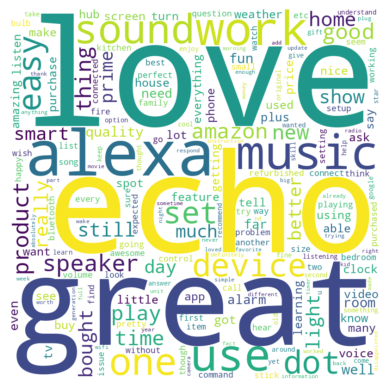

In [ ]:
#Use the WordCloud to generate a Cloud of word highlighting those word with more frequency among the reviews

common_words=''

for i in data.reviews:
    i = str(i)
    word = i.split()
    common_words += " ".join(word)+" "
print(common_words)


wordcloud = wordcloud.WordCloud(width = 800, height = 800, background_color='white', min_font_size=10, collocations=False).generate(common_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Encode target labels with value between 0 and n_classes-1. Use LabelEncoder model from sklearn.preprocessing to do this process.
#Use one hot encoding to transform the labels into categorical format

Y = data['feedback']

Y = LabelEncoder().fit_transform(Y)


Y = to_categorical(Y)



In [ ]:
#Convert the reviews into vector arrays. For this process use Tokenizer model from keras.preprocessing.text packages

tokenizer = Tokenizer(num_words=500, split=' ')


tokenizer.fit_on_texts(data['reviews'].values)

X = tokenizer.texts_to_sequences(data['reviews'].values)

print("number of rows:{}\nnumber of columns: {}".format(len(X), len(X[0])))
print(X[0:5])

X = pad_sequences(X)

print("\nnumber of rows:{}\nnumber of columns: {}".format(len(X), len(X[0])))
print(X[0:5])





number of rows:3150
number of columns: 2
[[1, 2], [172], [181, 99, 229, 468, 4, 287, 42, 469, 379, 6, 57, 68, 62, 252, 20], [89, 36, 45, 136, 94, 62, 21, 253, 6, 66, 11, 99, 5, 34], [5]]

number of rows:3150
number of columns: 165
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 

In [ ]:
#Implement the Long Short Term Memory and print the configuration of your model

model = Sequential()
model.add(Embedding(5000, 120, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 165, 120)          600000    
                                                                 
 spatial_dropout1d_5 (Spati  (None, 165, 120)          0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 176)               209088    
                                                                 
 dense_8 (Dense)             (None, 2)                 354       
                                                                 
Total params: 809442 (3.09 MB)
Trainable params: 809442 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Splitting the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20)
print("Number of samples for training [reviews]:{}\nNumber of sample for training [Labels]:{}".format(X_train.shape,y_train.shape))
print("Number of samples for testing [reviews]:{}\nNumber of sample for testing [Labels]:{}".format(X_test.shape,y_test.shape))


Number of samples for training [reviews]:(2520, 165)
Number of sample for training [Labels]:(2520, 2)
Number of samples for testing [reviews]:(630, 165)
Number of sample for testing [Labels]:(630, 2)


In [ ]:
# compile the model


# fit the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose='auto')

model.save('customer_review.h5')

Epoch 1/5
79/79 [==============================] - 64s 748ms/step - loss: 0.3084 - accuracy: 0.9163
Epoch 2/5
79/79 [==============================] - 59s 739ms/step - loss: 0.2054 - accuracy: 0.9234
Epoch 3/5
79/79 [==============================] - 56s 704ms/step - loss: 0.1445 - accuracy: 0.9413
Epoch 4/5
79/79 [==============================] - 60s 760ms/step - loss: 0.1130 - accuracy: 0.9528
Epoch 5/5
79/79 [==============================] - 57s 710ms/step - loss: 0.1007 - accuracy: 0.9560


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate out model using the accuracy metric
#Use the function predict to evaluate the performance of you model using the testing dataset
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.922


In [ ]:
#Use argmax from NumPy library to transform the predicted labels and the label of your testing dataset

sentiment_prediction = model.predict(X_test)
predicted_inverse = np.argmax(sentiment_prediction,axis=1)
y_test_inverse = np.argmax(y_test,axis=1)

20/20 [==============================] - 2s 92ms/step


In [ ]:
#Use classification_report method from sklearn.metric library to evaluate the performance of you model
##Print the table with the corresponding metric evaluation: precision, recall, f1-score, support, accuracy, macro avg, and weighted avg.
target_name = ["Class {}".format(i) for i in range(2)]

print(classification_report(y_test_inverse,predicted_inverse,target_names=target_name))

              precision    recall  f1-score   support

     Class 0       0.52      0.34      0.41        50
     Class 1       0.94      0.97      0.96       580

    accuracy                           0.92       630
   macro avg       0.73      0.66      0.68       630
weighted avg       0.91      0.92      0.91       630



In [ ]:
from keras.models import load_model

# Load the pre-trained model
model = load_model('customer_review.h5')

def preprocess_review(review):
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    tokenizer = Tokenizer()
    review_words = [word.lower() for word in nltk.word_tokenize(review) if word.isalpha() and word.lower() not in stop_words]

    tokenizer.fit_on_texts(review_words)

    review_sequences = tokenizer.texts_to_sequences([review_words])

    padded_review = pad_sequences(review_sequences, maxlen=X.shape[1])

    return padded_review

# Get user input for the product review
user_review = input("Enter your product review: ")

# Preprocess the user's review
preprocessed_review = preprocess_review(user_review)

# Debugging: Print preprocessed review
print("Preprocessed Review:", preprocessed_review)

# Make predictions using the trained model
predicted_sentiment = model.predict(preprocessed_review)

# Debugging: Print predicted sentiment
print("Predicted Sentiment (Raw):", predicted_sentiment)

# Convert the predicted sentiment to a readable format (assuming two classes)
predicted_label = np.argmax(predicted_sentiment)

# Debugging: Print predicted label
print("Predicted Label:", predicted_label)

# Print the predicted sentiment
if predicted_label == 0:
    print("Predicted sentiment: Negative")
else:
    print("Predicted sentiment: Positive")


Enter your product review: good product


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed Review: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]]
1/1 [==============================] - 0s 323ms/step
Predicted Sentiment (Raw): [[2.2935338e-04 9.9977070e-01]]
Predicted Label: 1
Predicted sentiment: Positive
